=== Resultados ===
Dimensión base (k): 24
Fracción de energía retenida: 1.0000
Masa real: 6.000 M_sun
Masa estimada (subrogado): 6.000 M_sun
Error en estimación: 0.0000 M_sun
Mejor match (obs vs sur): 0.4352
Error ROM medio (sur vs exacto): 0.1910
Tiempo barrido subrogado (24 masas): 2.6512 s
Tiempo surrogate puro: 0.0053 s
Tiempo exacto: 0.2570 s
Speedup: 48.1x


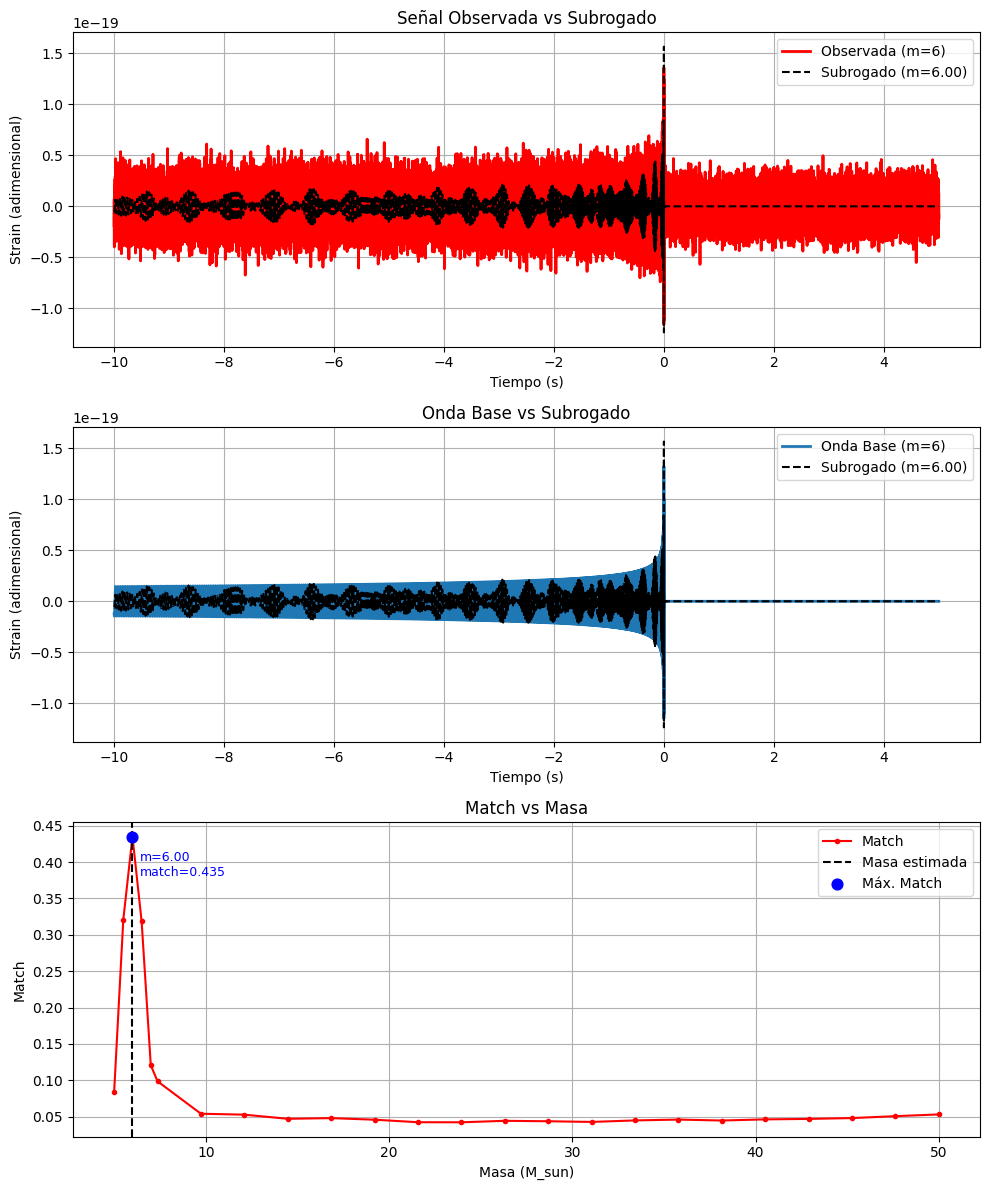

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.types import TimeSeries
from scipy.interpolate import Rbf
from pycbc.psd import aLIGOZeroDetHighPower

# ================================
# Configuración reproducible
# ================================
np.random.seed(42)
delta_t = 1.0 / 4096
f_low = 20.0
apx = "SEOBNRv4_ROM"

# ================================
# Función para centrar la onda
# ================================
def safe_time_slice(h, t_before=10, t_after=5):
    t_peak = h.sample_times[np.argmax(abs(h))]
    t_start = max(h.start_time, t_peak - t_before)
    t_end   = min(h.end_time,   t_peak + t_after)
    return h.time_slice(t_start, t_end)

# ================================
# Señal limpia y señal observada con ruido
# ================================
m_real = 6
hp_clean, _ = get_td_waveform(approximant=apx,
                              mass1=m_real, mass2=m_real,
                              delta_t=delta_t, f_lower=f_low)
hp_clean = safe_time_slice(hp_clean, t_before=10, t_after=5)
hp_clean_np = hp_clean.numpy()
times = hp_clean.sample_times.numpy()
N = len(hp_clean_np)

# Señal observada (con ruido)
sigma_noise = 0.1 * np.max(np.abs(hp_clean_np))
noise = np.random.normal(0, sigma_noise, size=N)
hp_obs = hp_clean_np + noise

# ================================
# Conjunto de entrenamiento
# ================================
mass_range = np.unique(np.concatenate([
    np.linspace(5, 50, 20),
    [5, 5.5, 6, 6.5, 7]
]))

W_list = []
for m in mass_range:
    h, _ = get_td_waveform(approximant=apx,
                           mass1=m, mass2=m,
                           delta_t=delta_t, f_lower=f_low)
    h = safe_time_slice(h, t_before=10, t_after=5)
    h_arr = np.zeros(N)
    L = min(len(h.numpy()), N)
    h_arr[:L] = h.numpy()[:L]
    W_list.append(h_arr)

W = np.array(W_list).T

# ================================
# Base reducida (SVD)
# ================================
U, S, Vt = np.linalg.svd(W, full_matrices=False)
k = min(50, U.shape[1])
basis = U[:, :k]
coeffs = basis.T @ W

# ================================
# Interpoladores (RBF)
# ================================
rbf_list = [Rbf(mass_range, coeffs[i, :], function="multiquadric", smooth=0.01) for i in range(k)]

def surrogate(m):
    coeff_pred = np.array([rbf(m) for rbf in rbf_list])
    return basis @ coeff_pred

# ================================
# Estimación de masa a partir de la señal observada
# ================================
matches = []
start_sub = time.time()
for m in mass_range:
    h_try = surrogate(m)
    ts_obs = TimeSeries(hp_obs, delta_t=delta_t)
    ts_try = TimeSeries(h_try, delta_t=delta_t)

    flen = len(ts_obs) // 2 + 1
    psd = aLIGOZeroDetHighPower(flen, ts_obs.delta_f, f_low)
    mm, _ = match(ts_obs, ts_try, psd=psd, low_frequency_cutoff=f_low)
    matches.append(mm)
time_sub = time.time() - start_sub

best_idx = np.argmax(matches)
m_est = mass_range[best_idx]
best_match = matches[best_idx]
error_m = abs(m_est - m_real)

# ================================
# Tiempo de generación exacta
# ================================
start_exact = time.time()
h_exact, _ = get_td_waveform(approximant=apx,
                             mass1=m_real, mass2=m_real,
                             delta_t=delta_t, f_lower=f_low)
h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
h_exact_arr = np.zeros(N)
L = min(len(h_exact.numpy()), N)
h_exact_arr[:L] = h_exact.numpy()[:L]
time_exact = time.time() - start_exact

# Fracción de energía retenida en la base reducida
energy_retained = np.sum(S[:k]**2) / np.sum(S**2)

# Error ROM medio: surrogate vs onda exacta (para el set de entrenamiento)
rom_errors = []
for m in mass_range:
    h_exact, _ = get_td_waveform(approximant=apx,
                                 mass1=m, mass2=m,
                                 delta_t=delta_t, f_lower=f_low)
    h_exact = safe_time_slice(h_exact, t_before=10, t_after=5)
    h_exact_arr = np.zeros(N)
    L = min(len(h_exact.numpy()), N)
    h_exact_arr[:L] = h_exact.numpy()[:L]
    h_sur = surrogate(m)
    rom_errors.append(np.linalg.norm(h_sur - h_exact_arr) / np.linalg.norm(h_exact_arr))
rom_error_mean = np.mean(rom_errors)

# Tiempo de surrogate puro (una sola masa)
start_one = time.time()
_ = surrogate(m_est)
time_one_sur = time.time() - start_one

# Speedup
speedup = time_exact / time_one_sur if time_one_sur > 0 else np.inf

# ================================
# Resultados
# ================================
print("=== Resultados ===")
print(f"Dimensión base (k): {k}")
print(f"Fracción de energía retenida: {energy_retained:.4f}")
print(f"Masa real: {m_real:.3f} M_sun")
print(f"Masa estimada (subrogado): {m_est:.3f} M_sun")
print(f"Error en estimación: {error_m:.4f} M_sun")
print(f"Mejor match (obs vs sur): {best_match:.4f}")
print(f"Error ROM medio (sur vs exacto): {rom_error_mean:.4f}")
print(f"Tiempo barrido subrogado ({len(mass_range)} masas): {time_sub:.4f} s")
print(f"Tiempo surrogate puro: {time_one_sur:.4f} s")
print(f"Tiempo exacto: {time_exact:.4f} s")
print(f"Speedup: {speedup:.1f}x")

# ================================
# Gráficos
# ================================
plt.figure(figsize=(10,12))

# Gráfico 1: señal observada + ruido vs subrogado
plt.subplot(3,1,1)
plt.plot(times, hp_obs,color='red', label=f"Observada (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--",color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Strain (adimensional)")
plt.title("Señal Observada vs Subrogado")
plt.legend()
plt.grid()

# Gráfico 2: onda base vs subrogado
plt.subplot(3,1,2)
plt.plot(times, hp_clean_np, label=f"Onda Base (m={m_real})", lw=2)
plt.plot(times, surrogate(m_est), "--", color='black', label=f"Subrogado (m={m_est:.2f})")
plt.xlabel("Tiempo (s)")
plt.ylabel("Strain (adimensional)")
plt.title("Onda Base vs Subrogado")
plt.legend()
plt.grid()

# Gráfico 3: match vs masa
plt.subplot(3, 1, 3)
plt.plot(mass_range, matches, "-o", ms=3, color="red", label="Match")
plt.axvline(m_est, linestyle="--", color='black', label="Masa estimada")

# punto del máximo
plt.scatter(m_est, best_match, color="blue", s=60, zorder=5, label="Máx. Match")
plt.text(m_est + 0.4, best_match - 0.02, 
         f"m={m_est:.2f}\nmatch={best_match:.3f}",
         fontsize=9, color="blue", va="top")

plt.xlabel("Masa (M_sun)")
plt.ylabel("Match")
plt.title("Match vs Masa")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
